# Create genetic perturabation data


## 1. import the necessary libraries

In [1]:
import xpert as xp
from xpert.data.utils import get_info_txt
import scanpy as sc
import os
import pickle
import warnings
import logging
warnings.filterwarnings('ignore')
sc.settings.verbosity = 0
logging.getLogger('scanpy').setLevel(logging.ERROR)
logging.getLogger('anndata').setLevel(logging.ERROR)


## 2. load original adata file of perturbation data

In [2]:
adata = sc.read('../../data/Norman2019/NormanWeissman2019_filtered.h5ad')
adata

AnnData object with n_obs × n_vars = 111445 × 33694
    obs: 'guide_id', 'read_count', 'UMI_count', 'coverage', 'gemgroup', 'good_coverage', 'number_of_cells', 'tissue_type', 'cell_line', 'cancer', 'disease', 'perturbation_type', 'celltype', 'organism', 'perturbation', 'nperts', 'ngenes', 'ncounts', 'percent_mito', 'percent_ribo'
    var: 'ensemble_id', 'ncounts', 'ncells'

add obs.column with 'perturbation_new' and 'cell_type_new', which is used to perform data proprecessing.

In [3]:
def get_perturbation(x):
    return '; '.join(x['perturbation'].split('_'))

adata.obs['perturbation_new'] = adata.obs.apply(get_perturbation, axis=1)
adata.obs['celltype_new'] = adata.obs['celltype']

def get_perturbation_group(x):
    return ' | '.join([x['perturbation_new'], x['celltype_new']])
perturbation_group = adata.obs.apply(get_perturbation_group, axis=1)
adata.obs['perturbation_group'] = perturbation_group

adata.obs['sgRNA_new'] = 'control'

## 3. generate Pert_Data object



In [4]:
# parameters

pert_cell_filter = 100 # this is used to filter perts, cell number less than this will be filtered
seed = 2024 # this is the random seed
split_type = 1 # 1 for unseen perts; 0 for unseen celltypes
split_ratio = [0.7, 0.2, 0.1] # train:test:val; val is used to choose data, test is for final validation
var_num = 5000 # selecting hvg number
num_de_genes = 20 # number of de genes
bs_train = 32 # batch size of trainloader
bs_test = 32 # batch size of testloader
data_dir = '../../data/Norman2019/'

In [5]:
# Create Pert_Data object
pert_data = xp.data.Byte_Pert_Data(
    prefix='Norman2019',
    pert_cell_filter=pert_cell_filter,
    seed=seed,
    split_ratio=split_ratio,
    split_type=split_type,
    var_num=var_num,
    num_de_genes=num_de_genes,
    bs_train=bs_train,
    bs_test=bs_test
)

# Complete data processing pipeline
print("Step 1: Reading files...")
pert_data.read_files(adata)

print("Step 2: Filtering perturbations...")
pert_data.filter_perturbation()

print("Step 3: Preprocessing adata and selecting HVGs...")
pert_data.get_and_process_adata(var_num=pert_data.var_num)

print("Step 4: Setting control barcodes...")
pert_data.set_control_barcode()

print("Step 5: Calculating E-distances...")
pert_data.get_edis_2()

print("Step 6: Filtering sgRNAs...")
pert_data.adata_split.obs['sgRNA_new'] = 'control'
pert_data.filter_sgRNA()

print("Step 7: Data splitting...")
pert_data.data_split(split_type=1, test_perts=None)

print("Step 8: Getting differential genes...")
pert_data.get_de_genes()

print("Step 9: Saving processed data...")
# Save the processed data
pickle.dump(pert_data, open(os.path.join(data_dir, 'pert_data.pkl'), 'wb'))

print("Pert_Data object generation completed!")
print(f"Final dataset shape: {pert_data.adata_split.shape}")
print(f"Number of perturbation groups: {len(pert_data.filter_perturbation_list)}")

Step 1: Reading files...
========== read file finished!
Step 2: Filtering perturbations...
retain_pert_num is: 225
filtered pert num is:  12


100%|██████████| 236/236 [00:03<00:00, 73.45it/s]


========== filter perturbation finished!
Step 3: Preprocessing adata and selecting HVGs...
len of exclude_var_list is 4
len of pert_gene_list is 343
len of final var_names is 5040
========== get var genes finished!
this is new version
Step 4: Setting control barcodes...


100%|██████████| 224/224 [00:03<00:00, 69.05it/s]


========== set control barcodes finished!
Step 5: Calculating E-distances...
Step 6: Filtering sgRNAs...


0it [00:00, ?it/s]


Step 7: Data splitting...
========== data split finished!
Step 8: Getting differential genes...


100%|██████████| 224/224 [01:04<00:00,  3.48it/s]


========== get de genes finished!
Step 9: Saving processed data...
Pert_Data object generation completed!
Final dataset shape: (110554, 5040)
Number of perturbation groups: 224


## 4. Pert_Data Information Analysis and Visualization

1. Analyzing cell count distribution...


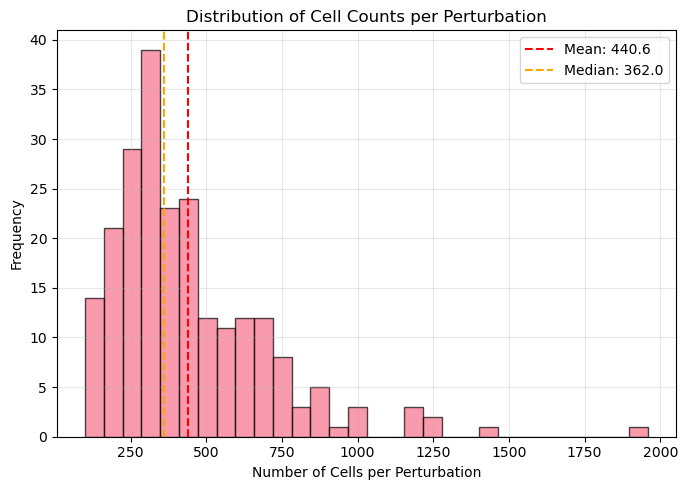

   - Mean cells per perturbation: 440.6
   - Median cells per perturbation: 362.0
   - Total perturbations: 224

2. Analyzing E-distance distribution...
   - Mean E-distance: 38.914
   - Median E-distance: 28.915
   - Min E-distance: 0.285
   - Max E-distance: 203.848


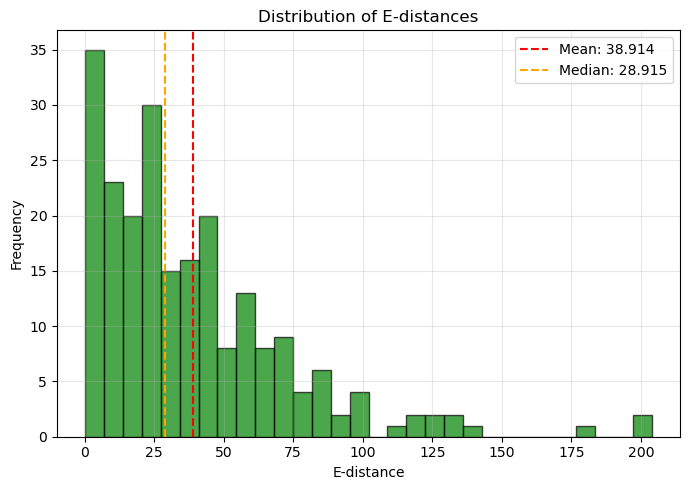


3. Generating UMAP plot for specific perturbation...
   - Selected perturbation: AHR | lymphoblasts
   - Cell count: 558


/nfs/public/lichen/software/miniconda3/envs/scGPT_2/lib/python3.10/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/nfs/public/lichen/software/miniconda3/envs/scGPT_2/lib/python3.10/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/nfs/public/lichen/software/miniconda3/envs/scGPT_2/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:842: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/nfs/public/lichen/software/miniconda3/envs/scGPT_2/lib/python3.10/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/nfs/public/lichen/software/miniconda3/envs/scGPT_2/lib

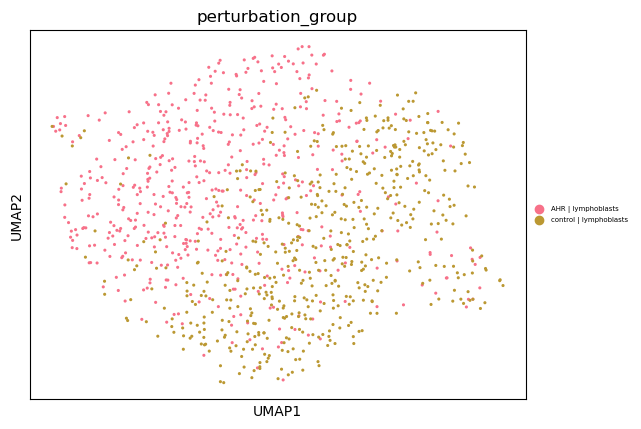


DETAILED PERTURBATION ANALYSIS

Top 10 perturbations by cell count:
  KLF1 | lymphoblasts: 1960 cells
  BAK1 | lymphoblasts: 1457 cells
  CEBPE | lymphoblasts: 1233 cells
  CEBPE_RUNX1T1 | lymphoblasts: 1219 cells
  UBASH3B | lymphoblasts: 1202 cells
  ETS2 | lymphoblasts: 1201 cells
  TBX3_TBX2 | lymphoblasts: 1167 cells
  OSR2 | lymphoblasts: 1003 cells
  SLC4A1 | lymphoblasts: 1000 cells
  SET | lymphoblasts: 986 cells

Perturbation type distribution:
  control: 11855 cells
  KLF1: 1960 cells
  BAK1: 1457 cells
  CEBPE: 1233 cells
  CEBPE_RUNX1T1: 1219 cells
  UBASH3B: 1202 cells
  ETS2: 1201 cells
  TBX3_TBX2: 1167 cells
  OSR2: 1003 cells
  SLC4A1: 1000 cells
  SET: 986 cells
  ELMSAN1: 937 cells
  ETS2_CNN1: 905 cells
  MAP2K6: 878 cells
  FOXF1: 874 cells
  C19orf26: 872 cells
  FOXA1: 851 cells
  UBASH3A: 819 cells
  UBASH3B_OSR2: 796 cells
  DUSP9_ETS2: 787 cells
  RUNX1T1: 779 cells
  MEIS1: 776 cells
  MAPK1: 765 cells
  CNN1: 765 cells
  MAP7D1: 751 cells
  ZBTB25: 740 cel

In [ ]:
# =============================================================================
# Pert_Data Information Analysis and Visualization
# =============================================================================

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")

# --------- 1. 分布相关的两个统计图分开画 ---------
print("1. Analyzing cell count distribution...")
pert_cell_counts = []
pert_names = []
for pert in pert_data.filter_perturbation_list:
    cell_count = len(pert_data.adata_split[pert_data.adata_split.obs['perturbation_group'] == pert])
    pert_cell_counts.append(cell_count)
    pert_names.append(pert.split(' | ')[0])  # 只取gene name

mean_cells = np.mean(pert_cell_counts)
median_cells = np.median(pert_cell_counts)

# 单独画：每个扰动的细胞数量分布（直方图）
fig1, ax1 = plt.subplots(figsize=(7, 5))
ax1.hist(pert_cell_counts, bins=30, alpha=0.7, edgecolor='black')
ax1.set_xlabel('Number of Cells per Perturbation')
ax1.set_ylabel('Frequency')
ax1.set_title('Distribution of Cell Counts per Perturbation')
ax1.grid(True, alpha=0.3)
ax1.axvline(mean_cells, color='red', linestyle='--', label=f'Mean: {mean_cells:.1f}')
ax1.axvline(median_cells, color='orange', linestyle='--', label=f'Median: {median_cells:.1f}')
ax1.legend()
plt.tight_layout()
plt.show()

print(f"   - Mean cells per perturbation: {mean_cells:.1f}")
print(f"   - Median cells per perturbation: {median_cells:.1f}")
print(f"   - Total perturbations: {len(pert_cell_counts)}")

# --------- 2. E-distance分布（单独画） ---------
print("\n2. Analyzing E-distance distribution...")
fig2, ax2 = plt.subplots(figsize=(7, 5))
if hasattr(pert_data, 'filter_pert_edis') and pert_data.filter_pert_edis:
    edis_values = list(pert_data.filter_pert_edis.values())

    ax2.hist(edis_values, bins=30, alpha=0.7, edgecolor='black', color='green')
    ax2.set_xlabel('E-distance')
    ax2.set_ylabel('Frequency')
    ax2.set_title('Distribution of E-distances')
    ax2.grid(True, alpha=0.3)

    mean_edis = np.mean(edis_values)
    median_edis = np.median(edis_values)
    ax2.axvline(mean_edis, color='red', linestyle='--', label=f'Mean: {mean_edis:.3f}')
    ax2.axvline(median_edis, color='orange', linestyle='--', label=f'Median: {median_edis:.3f}')
    ax2.legend()

    print(f"   - Mean E-distance: {mean_edis:.3f}")
    print(f"   - Median E-distance: {median_edis:.3f}")
    print(f"   - Min E-distance: {np.min(edis_values):.3f}")
    print(f"   - Max E-distance: {np.max(edis_values):.3f}")

else:
    ax2.text(0.5, 0.5, 'E-distance data not available',
             ha='center', va='center', transform=ax2.transAxes)
    ax2.set_title('E-distance Distribution (Not Available)')
    print("   - E-distance data not available")
plt.tight_layout()
plt.show()

# --------- 3. UMAP单独画 ---------
print("\n3. Generating UMAP plot for specific perturbation...")
if pert_cell_counts:
    # Get perturbations sorted by cell count
    pert_cell_df = pd.DataFrame({
        'perturbation': pert_data.filter_perturbation_list,
        'cell_count': pert_cell_counts
    }).sort_values('cell_count', ascending=False)
    # 选一个cell丰度前25%里的扰动
    top_25_percent = int(len(pert_cell_df) * 0.25)
    selected_pert = pert_cell_df.iloc[top_25_percent]['perturbation']
    selected_cell_count = pert_cell_df.iloc[top_25_percent]['cell_count']

    print(f"   - Selected perturbation: {selected_pert}")
    print(f"   - Cell count: {selected_cell_count}")

    try:
        pert_data.plot_umap(
            pert=selected_pert,
            point_size=20,
            color=['perturbation_group'],
            return_adata=False
        )
    except Exception as e:
        print(f"   - UMAP generation failed: {e}")
else:
    print("   - No perturbation data available for UMAP plot.")

# ======= 4. 不画图，只保留详细统计信息 =======
# 汇报数据信息
print("\n" + "=" * 60)
print("DETAILED PERTURBATION ANALYSIS")
print("=" * 60)

# Top 10 perturbations by cell count
print("\nTop 10 perturbations by cell count:")
pert_cell_df = pd.DataFrame({
    'perturbation': pert_data.filter_perturbation_list,
    'cell_count': pert_cell_counts
}).sort_values('cell_count', ascending=False)
top_10_perts = pert_cell_df.head(10)
for idx, row in top_10_perts.iterrows():
    print(f"  {row['perturbation']}: {row['cell_count']} cells")

# Perturbation type distribution
print(f"\nPerturbation type distribution:")
pert_type_counts = pert_data.adata_split.obs['perturbation_new'].value_counts()
for pert_type, count in pert_type_counts.items():
    print(f"  {pert_type}: {count} cells")

# Cell type distribution
print(f"\nCell type distribution:")
celltype_counts = pert_data.adata_split.obs['celltype_new'].value_counts()
for celltype, count in celltype_counts.items():
    print(f"  {celltype}: {count} cells")

print("\nAnalysis completed!")
